# Naive Bayes Classifier with Kernel Density Estimators

The following code trains a Naive Bayes Classifier with KDEs to predict the distance between the Raspberrry Pis. The code below is adapted from Chapter 5 of Jake VanderPlas' *Python Data Science Handbook* and utilizes the `KDECLassifier` class from the same source.

In [1]:
from kde_classifier import KDEClassifier
import pandas as pd
from pathlib import Path
from pi_pact_sort import categorize, bin_categorize
import pickle
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

DROP_COLUMNS = ['ADDRESS', 'TIMESTAMP', 'UUID', 'MAJOR', 'MINOR', 'TX POWER', 'TEMPERATURE',
                'HUMIDITY', 'PRESSURE', 'PITCH', 'ROLL', 'YAW', 'SCAN']
SAMPLE_SIZE = 30000
np.random.seed(0)


"""Creates a Naive Bayes classifier with KDE to predict a distance range given RSSI values and other variables.

   KDEClassifier class adapted from Chapter 5 of the Python Data Science Handbook by Jake VanderPlas:
   https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html
"""

# Initialize DataFrame
data: pd.DataFrame = pd.DataFrame(columns=['RSSI', 'DISTANCE'])
data_copy: pd.DataFrame = data.copy()
csv_file: Path
for csv_file in Path('.').glob('indoor-noObstruct-SenseHat*/*.csv'):
    datapart: pd.DataFrame = pd.read_csv(csv_file)
    for column in DROP_COLUMNS:
        if column in datapart.columns:
            datapart = datapart.drop([column], 1)
    data_copy = data_copy.append(datapart)

# Categorize distance
data_copy['DISTANCE'] = data_copy['DISTANCE'].map(bin_categorize)

# Sample data from each distance category
for value in data_copy['DISTANCE'].unique():
    datapart = data_copy[data_copy.DISTANCE == value]
    datapart = datapart.sample(SAMPLE_SIZE, random_state=1)
    data = data.append(datapart)

# Assign features and labels
X: np.array = data.drop(['DISTANCE'], 1).to_numpy()
y: np.array = data['DISTANCE'].to_numpy(dtype=int)

# Hyperparameter tuning
# Code adapted from Chapter 5 of the Python Data Science Handbook by Jake VanderPlas:
# https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html
bandwidths = np.around(np.linspace(0.5, 1, 5), decimals=4)
grid = GridSearchCV(KDEClassifier(), {'bandwidth': bandwidths}, n_jobs=1)
grid.fit(X, y)

GridSearchCV(estimator=KDEClassifier(), n_jobs=1,
             param_grid={'bandwidth': array([0.5  , 0.625, 0.75 , 0.875, 1.   ])})

In [2]:
print(grid.best_params_)
print('accuracy =', grid.best_score_)

{'bandwidth': 0.625}
accuracy = 0.6805333333333333


In [3]:
with open("nb-kde-models/2var-binary-nb-kde-model.pickle", "wb") as f:
    pickle.dump(grid.best_estimator_, f)

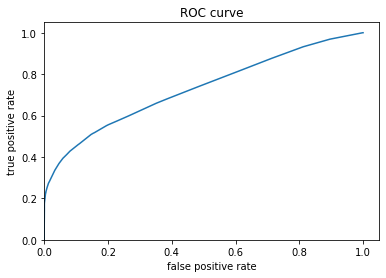

In [4]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
probs = grid.best_estimator_.predict_proba(X)
fpr, tpr, _ = roc_curve(y, probs[:, 1])
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)
plt.savefig(str(Path('./nb-kde-models/2var-binary-nb-kde-model-roc-curve.png')))